# 與學習有關的技巧
本章要說明在神經網路的學中，成為關鍵的重要部分。本章挑選的主題包括，找出最佳參數的最佳化方法、權重參數的預設值、超參數的設定方法等，每個都是在神經網路的學中，十分重要的主題。另外，還會扼要說明執行Weight decay( 權重衰減 )與 Dropout 等正規化方法，當作過度學解決對策。最後，簡單說明近年來眾多研究中常用到的 Batch Normalization 手法，可以快速進行神經網路( 深度學習 )的學習。所以，讓我們開始本章的內容吧!


## 6.1 更新參數
神經網路的學習目的，就是找出可以盡量縮小損失函數的參數，亦即找出最佳參數。<br><br>

為了找出最佳化參數，計算了參數的梯度( 微分 )。重複執行利用參數的梯度，往梯度方向進行更新參數，最後會逐漸趨近最佳參數，這種方法稱作SGD，是非常單純的作法，但，還有比SGD更聰明的方法存在。以下要說明SGD的缺點，並介紹其他最佳化手法。


### 6.1.1 SGD
$
W ← W - \eta\frac{\partial{L}}{\partial{W}} \tag{6.1}
$
這裡的更新權重參數為$W$，損失函數的梯度為$\frac{\partial{L}}{\partial{W}}$。$\eta$代表學習率，實際上使用的是事先決定的0.01或0.001等數值。以下實現SGD。


In [2]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


### 說明
初始化時的引數lr代表learning rate( 學習率 )，並且把學率當作實例變數。另外，還定義了update(self, params, grads)方法。在SGD中，會重複呼叫這個方法。我們來使用SGD看看。


### SGD的缺點
SGD很單純，也很容易執行，但遇到部分問題，可能會變得很沒有效率。以下將藉由思考函數最小值問題，指出SGD的缺點。<br>
$
f(x,y) = \frac{1}{20}x^2 + y^2 \tag{6.2}
$<br>
由算式可知，這個梯度的特色是，往$y$軸方向變大，往$x$軸方向就會變小。<br><br>

換句話說，SGD的缺點是，函數的形狀如果沒有**等向性**，非延伸形狀的函數，就會以沒有效率的路徑進行探索。為了改善SGD的缺點，接下來將介紹Momentum、AdaGrad、Adam等取代SGD的3種手法。


### 6.1.2 Momentum
Momentum的意思是「動量」與物理有關係。此手法可以用下列算式表示。<br>
$
v ← \alpha v - \eta\frac{\partial{L}}{\partial{W}} \tag{6.3}
$<br>
$
W ← W + v \tag{6.4}
$<br>
和前面的SGD一樣，$W$是更新的權重參數，$\frac{\partial{L}}{\partial{W}}$是與$W$有關的損失函數梯度，$\eta$代表學習率。這裡出現了新的變數$v$，站在物理的角度，$v$代表著「速度」。算式( 6.3 )代表，物體往梯度方向受力，並將這個力量加上物體速度$v$( 6.4 )的物理定律。<br>

另外，算式( 6.3 )還出現了$\alpha v$，這是當物體沒有受力時，逐漸減速的功能( $\alpha$ 設定為0.9等數值 )。站在物理學的角度，相當於地面磨擦力或是空氣阻力。以下是Momentum的執行過程。


In [3]:
import numpy as np
class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]
        

### 6.1.3 AdaGrad
在神經網路的學習中，學習率的值分常重要( 算式中顯示為$\eta$ )。學習率太小，會花費太多時間浪費在學習上，反之則會無法正確學習。 <br><br>

有個學習率有關的有效技巧，稱為**學習率衰減( learning rate decay )** 逐漸降低學習率的概念，相當於統一降低參數「整個」學習率。進一步發展後，就成為AdaGrad，此手法為針對「每個」參數，準備「客製」值。<br><br>

AdaGrad是適應各個參數的元素，一邊調整學習率，一邊學習的手法( AdaGrad 的 Ada 為 Adaptive )。接下來，用算式來顯示AdaGrad的更新方法。<br>
$
h ← h + \frac{\partial{L}}{\partial{W}} \bigodot \frac{\partial{L}}{\partial{W}} \tag{6.5} 
$ <br>
$
W ← W -  \eta \frac{1}{\sqrt{h}} \frac{\partial{L}}{\partial{W}} \tag{6.6}
$ <br>

和前面的SGD一樣，$W$是更新的權重參數，$\frac{\partial{L}}{\partial{W}}$是與$W$有關的損失函數梯度，$\eta$代表學習率。這裡出現了新的變數$h$，如算式 ( 6.5 )所示，$h$維持為前面提到的梯度值平方和( 算式 ( 6.5 )的$\bigodot$代表矩陣各元素相乘再加總 )。更新參數時，乘上$\frac{1}{\sqrt{h}}$，調整學習規模。這是代表在參數的元素中，經常變動( 放大 )的元素，由於$h$在分母位置，因此學習率會因故而變小。由於經常變動的參數，學習率會逐漸變小，所以我們可以針對參數的各個元素，執行學習率衰減。接下來，我們來執行他。<br><br>

{Note} AdaGrad是把過去所有的梯度當作平方和，全都記錄下來。實際上，無限學習下去，更新量會變成0，完全不在更新。改善這個問題的手法，就是RMSPorp。其手法並非把過去所有的梯度一率加總，而是逐漸忘記過去的梯度，以大幅反應新梯度資料的方式加總。專有名詞稱作「指數移動平均」，以指數函數減少過去梯度的規模。


In [4]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


這裡必須注意到，最後一行加上了小數值1e-7這一點。這是為了避免當self.h[ key ]出現0時，發生除以0的問題。在大部分的深度學習框架中，這種小數值也可以設定成參數，這裡使用固定值1e-7。


### 6.1.4 Adam
Momentum是依照球在碗內來回滾動的物理定律為基準來移動，而AdaGrad是依照各個參數的元素，調整適應的更新步驟。假如將Momentum與AdaGrad相結合，就是Adam了!<br><br>

直覺來說，結合以上兩種手法的優點，可以有效探索參數空間。另外，還能進行超參數的「偏權值調整( 偏離校正 )」，這也是Adam的特色之一。接下來我們來執行他。


In [5]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


### 6.1.5 利用MNIST資料集比較更新手法
以下將以手寫辨識數字為對象，比較前面說明過的SGD、Momentum、AdaGrad、Adam等4種手法。確認每種手法的學習進展有何不同。<br>


===========iteration:0===========
SGD:2.3356935499363285
Momentum:2.3495937688707484
AdaGrad:2.2599566969872518
Adam:2.1726558339233732
===========iteration:100===========
SGD:1.433366440829821
Momentum:0.24454484979976798
AdaGrad:0.07795337499657798
Adam:0.18928479637271092
===========iteration:200===========
SGD:0.7557511755448117
Momentum:0.5039164917349346
AdaGrad:0.2647517351458038
Adam:0.4456197911372994
===========iteration:300===========
SGD:0.46452218201283313
Momentum:0.2523405908995795
AdaGrad:0.08783347095228952
Adam:0.15422570283039708
===========iteration:400===========
SGD:0.4704174609772213
Momentum:0.3013551476211603
AdaGrad:0.17092248345181155
Adam:0.2281373125609128
===========iteration:500===========
SGD:0.2867959998810909
Momentum:0.104164275617434
AdaGrad:0.03409116284227293
Adam:0.08045520347736985
===========iteration:600===========
SGD:0.3759763648898215
Momentum:0.15358101654230238
AdaGrad:0.05695617243652647
Adam:0.1110610053890109
===========iteration:700===

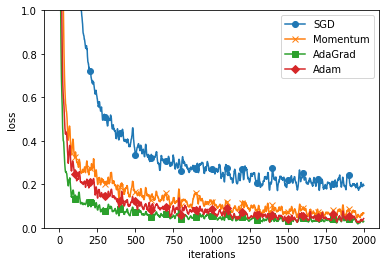

In [6]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex')) #載入父目錄檔案的設定
import numpy as np
import matplotlib.pyplot as plt
from dl_ex.dataset.mnist import load_mnist
from dl_ex.ch05.two_layer_net import TwoLayerNet
from dl_ex.common.util import smooth_curve
from dl_ex.common.multi_layer_net import MultiLayerNet
from dl_ex.common.optimizer import *

# 0:MNIST載入
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1:實驗設定
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:開始學習
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3.繪圖
%matplotlib inline
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


由圖可以看出，除了SGD外的3種手法的學速度的確較快，有時最後的辨識效能也比較好。


## 6.2 權重的預設值
在神經網路中，特別重要的就是權重的預設值。事實上，權重的預設值應該設定為哪種數值，常會影響到神經網路的學習成功與否。本節將針對建議的權重預設值來說明，利用實驗，確認實際的神經網路學習速度。<br><br>


### 6.2.1 權重的預設值變成0?
後面將會介紹 Weight decay ( 權重衰減 )手法，當作控制過度學習，提高一般化功能的技巧。其是以縮小權重參數值為目的，進行學習的手法。縮小權重值，可以避免過度學習。<br><br>

如果想要縮小權重值，預設值也盡量從小數值開始，這是屬於正攻法。想要縮小權重值，把權重的預設值全部設為0呢?其實，這是一個糟糕的想法，因為如此會造成不正確學習。<br><br>

為什麼預設值不能設為均一值(或是全部為0)?因為誤差反向傳播法中，所有的權重值都會均一更新。假設在雙層神經網路中，把第1層與第2層的權重設定為0，進行正向傳播時，因為輸入層的權重為0，會傳遞相同值給第2層神經元。第2層神經元全部輸入相同的值，在反向傳播時，第2層的權重會更新成一樣。因此，我們需要的是隨機的預設值。

### 6.2.2 隱藏層的活性化分布
觀察隱藏層的活性化，可以得到許多資料。以下進行一個簡單的實驗，觀察隱藏層的活性化會隨著權重的預設值產生何種變化。這裡進行的實驗室，在5層的神經網路中(活化函數使用Sigmoid函數)，傳遞隨機產生的輸入資料，利用分布圖繪製各層的活性化資料分布。

{Note} 這裡把活化函數之後的輸出資料稱為「活性化( Activation )」，但是根據文獻紀載，在各層之間流動的資料，稱可稱為活性化。


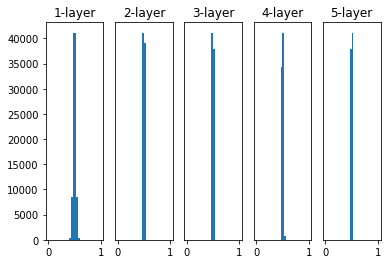

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個輸入資料
node_num = 100  # 各隱藏層的神經元數目
hidden_layer_size = 5  # 5層隱藏層
activations = {}  # 放置活性化資料的地方

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 隨機產生的初始權重預設值！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01 # 隨機初始化使用標準差為0.01的常態分配
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) 
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化開始！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 繪圖
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


如圖所示，能看出各層的活性化分布偏向0與1。這裡使用的Sigmoid函數為呈現s型曲線的函數，但隨著sigmoid函數的輸出趨近於0(或1)，該微分值也會趨近於0。因此，在偏向0與1的資料分布中，反向傳播的梯度值會逐漸變小、消失。這就是所謂的「梯度消失( gradient vanishing )」問題。在層數多的深度學習中，梯度消失會造成嚴重的問題。<br><br>

然而，若我們使用sd為0.01的常態分配做模擬，會發現集中分配在0.5附近。和前面偏向0與1不同，沒有引起梯度消失問題。可是，活性化分布出現特定偏差，在表現力方面，將會產生重大問題。因為，當多個神經元輸出幾乎一模一樣的數值時，就沒有存在的意義。例如，100個神經元的輸出幾乎相同數值，代表只用1個神經元，就能表現出一樣的情況。因此，活性化分布若出現偏差情況，會有「表現力受限」的問題，造成無法正確學習。因此我們需要在各層傳遞具有適當多樣性的資料。因此隨機初始化方法3、4為較佳的候選方法!!


### 6.2.3 利用MNIST資料集比較權重預設值
讓我們以實際資料為對象，提供不同的權重預設值，檢視對神經網路的學會造成何種影響。以下利用「std = 0.01」、「Xavier預設值」、「He預設值」等三種情況來進實驗。


===========iteration:0===========
std=0.01:2.3025329223238584
Xavier:2.3068515898035553
He:2.4803015208507606
===========iteration:100===========
std=0.01:2.302152343471332
Xavier:2.2519702797836554
He:1.5175834266480537
===========iteration:200===========
std=0.01:2.302735264092607
Xavier:2.098144666711304
He:0.7319833573173076
===========iteration:300===========
std=0.01:2.3021582359645043
Xavier:1.8847973160874443
He:0.5534199831863598
===========iteration:400===========
std=0.01:2.302234000741027
Xavier:1.4447272489606915
He:0.4889689942370519
===========iteration:500===========
std=0.01:2.3018832368353483
Xavier:0.9843404103452786
He:0.4049719497431833
===========iteration:600===========
std=0.01:2.302756489715163
Xavier:0.6522214689907871
He:0.1963144278841546
===========iteration:700===========
std=0.01:2.2961485640148056
Xavier:0.5169310970117199
He:0.3096802886582701
===========iteration:800===========
std=0.01:2.3002897065552235
Xavier:0.4507267570528286
He:0.2260211763418029

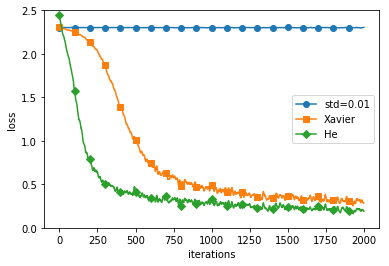

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 0:載入MNIST
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1:權重預設值設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

# 2:開始訓練==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3.繪圖==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


### 權重預設值的重要性
如圖，在這實驗中以5層神經網路為對象(各層有100個神經元)，使用ReLU當作活化函數。由結果可知，當「std=0.01」時，完全不會學習。因為正向傳播的數值非常小，集中在0(6.2.2小節有介紹)使得反向傳播時，計算的梯度也會變小，因而幾乎不會更新權重。相對來說「Xavier」、「He」預設值可以順利學習，且似乎He預設值表現較佳，學習速度較快。


## 6.3 Batch Normalization
在上一節，我們觀察了各層的活性化分布。這裡學到的重點是，只要妥善設定權重的預設值，就能讓各層的活性化分布具有適當廣度(神經元的多樣性)，就能順利進行學習。然而，為何我們不「強制性」調整活性化的分布?其實，以這種概念為基礎的手法，稱作Batch Normalization。


### 6.3.1 Batch Normalization演算法
Batch Normalization為2015年提出的方法，是很新的手法；但事實上，檢視ML的競賽結果，利用Batch Norm的優秀的成果案例比比皆是。<br><br>

為何 Batch Norm 如此受到矚目? 我們來看看他的優點。<br>
* 可以快速學習(因為能增加學習率)
* 不會過度依賴預設值( 不會對預設值產生過度反應 )
* 控制過度學習( 減少對Dropout等必要性 )
<br><br>

Batch Norm的概念如前所述，可以調整各層的活性化分布，變得具有適當廣泛性(神經元多元性)。因此，這裡把進行資料分布正規化的層級，即 Batch Normalization層，插入神經網路中，如圖所示。<br>
![6.3.1 Batch Normalization神經網路範例](./img/6.3.1.PNG)<br><br>

Batch Norm顧名思義，就是在進行學習時，以小批次為單位，依照各個小批次來進行正規化，就是進行讓資料分布平均為0，分散為1的正規化處理，以下說明算式。<br><br>

$
\mu _B ← \frac{1}{m} \sum _{i=1}^k xi 
$<br>

$
\sigma_B^2 ← \frac{1}{m} \sum_{k \atop i=1}(x_{i} - \mu_b)^2 \tag{6.7}
$<br>
$
\hat{x_i} ← \frac{x_i-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}
$<br><br>

這裡針對m個小批次B = {$x_1, \cdots{, x_m}$}輸入資料，計算平均$\mu_B$、分散$\sigma_B^2$。再進行讓輸入資料的平均為0，分散為1(適當分布)的正規化處理。然而，算是中的$\epsilon$是微小變異量，用來防止發生除以0的情況。<br><br>

算式( 6.7 )執行的處理是將小批次的輸入資料{$x_1, \cdots{, x_m}$}轉換成平均為0、分散為1的資料{$\hat{x_1}, \cdots{, \hat{x_m}}$}。在活化函數之前( 或是之後 )插入這種處理步驟，可以減少資料分布的偏差。<br><br>

此外，Batch Norm層是針對正規化後的資料，以原有的規模與移動來進行轉換，以算式顯示如下：<br>

$
y_i ← \gamma \hat{x_i} + \beta \tag{6.8}
$<br>

以上就是Batch Norm演算法，這種演算法將成為神經網路上的正向傳播。


### 6.3.2 Batch Normalization 的評價
接下來，要利用Batch Norm層，開始進行實驗。我們使用MNIST資料集，檢視使用了Batch Norm層與沒有使用時，學習速度的差異。


============== 1/16 ==============
epoch:0 | 0.094 - 0.092
epoch:1 | 0.097 - 0.124
epoch:2 | 0.097 - 0.161
epoch:3 | 0.097 - 0.182
epoch:4 | 0.097 - 0.201
epoch:5 | 0.097 - 0.22
epoch:6 | 0.097 - 0.238
epoch:7 | 0.097 - 0.261
epoch:8 | 0.097 - 0.283
epoch:9 | 0.097 - 0.296
epoch:10 | 0.097 - 0.316
epoch:11 | 0.097 - 0.328
epoch:12 | 0.097 - 0.336
epoch:13 | 0.097 - 0.36
epoch:14 | 0.097 - 0.372
epoch:15 | 0.097 - 0.379
epoch:16 | 0.097 - 0.393
epoch:17 | 0.097 - 0.407
epoch:18 | 0.097 - 0.417
epoch:19 | 0.097 - 0.422
============== 2/16 ==============
epoch:0 | 0.1 - 0.105
epoch:1 | 0.105 - 0.123
epoch:2 | 0.116 - 0.131
epoch:3 | 0.116 - 0.158
epoch:4 | 0.116 - 0.183
epoch:5 | 0.116 - 0.211
epoch:6 | 0.116 - 0.242
epoch:7 | 0.116 - 0.274
epoch:8 | 0.116 - 0.292
epoch:9 | 0.116 - 0.325
epoch:10 | 0.116 - 0.361
epoch:11 | 0.116 - 0.386
epoch:12 | 0.116 - 0.398
epoch:13 | 0.116 - 0.415
epoch:14 | 0.116 - 0.438
epoch:15 | 0.116 - 0.463
epoch:16 | 0.116 - 0.483
epoch:17 | 0.116 - 0.5
epoch:

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


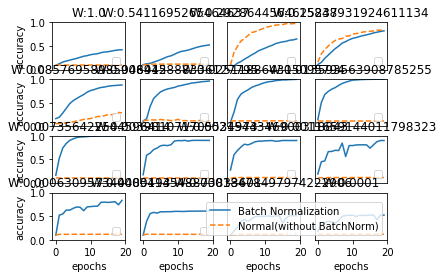

In [3]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex')) #載入父目錄檔案的設定
import numpy as np
import matplotlib.pyplot as plt
from  dl_ex.dataset.mnist import load_mnist
from dl_ex.common.multi_layer_net_extend import MultiLayerNetExtend
from dl_ex.common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 學習率衰減
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.繪圖==========
%matplotlib inline
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()


由圖可知，Batch Norm提升了學習速度。其中，實線是使用Batch Norm後的結果，虛線是沒有使用Batch Norm的結果：圖的標題顯示為權重預設值的標準差。<br><br.

如上說明，使用Batch Norm可以促進學習速度，而且權重的預設值會變穩健(不會過度依賴預設值)。由於Batch Norm具備這些特質，使得他能運用在各種場合。


## 6.4 正規化
在ML的問題中，經常出現**過度學習( _overfitting_ )**的情況。過度學習是指，過度適應訓練資料，而無法順利對應不含訓練資料的其他資料。ML的學習目標是擁有一般化能力，即使遇到沒有包含在訓練資料或是未曾見過的資料，也可以正確辨識。所以控制過度學習的技巧，就顯得格外重要。


### 6.4.1 過度學習
以下列出兩個造成過度學習的原因：
* 擁有大量參數，表現力高的模型
* 訓練資料太少
<br><br>

以下將刻意滿足這兩項條件，引起過度學習。這裡把MNIST資料集的訓練資料從原本的60000個限縮成300個，並且提高網路的複雜性，變成7層網路，每層的神經元有100個，活化函數使用ReLU。


epoch:0, train acc:0.09, test acc:0.1153
epoch:1, train acc:0.11, test acc:0.1225
epoch:2, train acc:0.12333333333333334, test acc:0.1307
epoch:3, train acc:0.14, test acc:0.1408
epoch:4, train acc:0.16333333333333333, test acc:0.1482
epoch:5, train acc:0.16666666666666666, test acc:0.1542
epoch:6, train acc:0.18666666666666668, test acc:0.1602
epoch:7, train acc:0.2, test acc:0.1661
epoch:8, train acc:0.21, test acc:0.1779
epoch:9, train acc:0.21333333333333335, test acc:0.1861
epoch:10, train acc:0.23333333333333334, test acc:0.198
epoch:11, train acc:0.2833333333333333, test acc:0.2172
epoch:12, train acc:0.31333333333333335, test acc:0.2324
epoch:13, train acc:0.34, test acc:0.2576
epoch:14, train acc:0.36333333333333334, test acc:0.2708
epoch:15, train acc:0.38, test acc:0.2796
epoch:16, train acc:0.4066666666666667, test acc:0.2972
epoch:17, train acc:0.41, test acc:0.3134
epoch:18, train acc:0.44, test acc:0.3281
epoch:19, train acc:0.44, test acc:0.3351
epoch:20, train acc:0.48

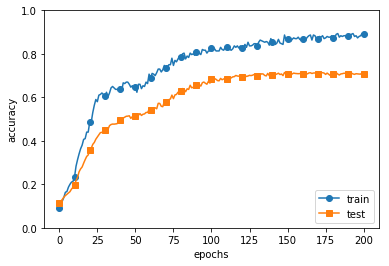

In [6]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex')) #載入父目錄檔案的設定
import numpy as np
import matplotlib.pyplot as plt
from dl_ex.dataset.mnist import load_mnist
from dl_ex.common.multi_layer_net import MultiLayerNet
from dl_ex.common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 為了製造過度學習而減少學習資料
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（權重衰減）設定 =======================
#weight_decay_lambda = 0 # weight decay
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.繪圖==========
%matplotlib inline
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


### 解說
由圖可知，計算出來的準確度，超過100 epoh 之後，幾乎是100% 。可是，測試資料與100%準確度有著很大的差距。這種辨識準確度的明顯差異，其實是過度適應訓練資料的結果。從這張圖可以看出，結果無法妥善對應不含訓練資料的一般化資料( 測試資料 )。


### 6.4.2 Weight decay
過去用來控制過度學習的手法是Weight decay( 權重衰減 )。在學習的過程中，針對擁有較大權重的部分，課以罰金，藉此種過度學習。因為原本過度學習就是因為權重參數值太大時，常發生的問題。<br><br>

神經網路的學習是以減少損失函數的值為目的。權重的平方範數(L2 norm)與損失函數相加，就可以抑制權重變大的情況。而權重衰減若用以符號表示，$\frac{1}{2}\lambda W^2$，此處的$\lambda$是控制正規化強度的超參數。$\lambda$值越大，會對取得的大權重值，課以較重的罰金。另外，$\frac{1}{2}$是為了把$\frac{1}{2}\lambda W^2$的微分結果變成$\lambda W$的調整用定數。<br><br>

Weight decay是針對全部的權重，將$\frac{1}{2}\lambda W^2$加入損失函數中。因此，計算權重的梯度時，將誤差反向傳播法的結果與正規化項目的微分$\lambda W$相加。<br><br>

接下來，開始進行實驗，以$\lambda = 1 $套用Weight dacay。



epoch:0, train acc:0.06333333333333334, test acc:0.0641
epoch:1, train acc:0.08666666666666667, test acc:0.0793
epoch:2, train acc:0.11666666666666667, test acc:0.1026
epoch:3, train acc:0.15666666666666668, test acc:0.1233
epoch:4, train acc:0.20666666666666667, test acc:0.149
epoch:5, train acc:0.26, test acc:0.1787
epoch:6, train acc:0.30666666666666664, test acc:0.2012
epoch:7, train acc:0.31, test acc:0.2222
epoch:8, train acc:0.3333333333333333, test acc:0.2371
epoch:9, train acc:0.35333333333333333, test acc:0.2497
epoch:10, train acc:0.38666666666666666, test acc:0.2683
epoch:11, train acc:0.4033333333333333, test acc:0.2835
epoch:12, train acc:0.41333333333333333, test acc:0.2999
epoch:13, train acc:0.43333333333333335, test acc:0.3035
epoch:14, train acc:0.44, test acc:0.3204
epoch:15, train acc:0.44666666666666666, test acc:0.3321
epoch:16, train acc:0.4633333333333333, test acc:0.342
epoch:17, train acc:0.4766666666666667, test acc:0.3528
epoch:18, train acc:0.4933333333333

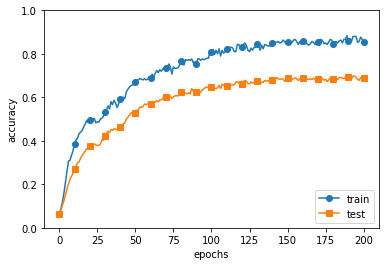

In [1]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex')) #載入父目錄檔案的設定
import numpy as np
import matplotlib.pyplot as plt
from dl_ex.dataset.mnist import load_mnist
from dl_ex.common.multi_layer_net import MultiLayerNet
from dl_ex.common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 減少學習數據以創建過度學習
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（權重衰減）設定 =======================
#weight_decay_lambda = 0 # weight decay
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 3.繪圖==========
%matplotlib inline
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


### 解說
(參考milti_lay_net.py)於兩個Affine層中間的loss function中，加上一個Weight dacay，即可達成圖片中的效果，訓練資料與測試資料的辨識準確度之間，存在著「差距」。但是與沒有使用Weight dacay的相比，差距縮小了不少，代表過度學習受到控制。此外，訓練資料的辨識準確度沒有達到100%，也是必須注意到的重點。


### 6.4.3 Dropout
雖然Weight decay可以輕鬆的執行，也能控制一定程度的過度學習，但是，當神經網路的模型變複雜時，單憑Weight decay，很難解決過度學習問題。因此，來有另外一個常見的作法，就是Droupout。<br><br>

Dropout是一邊隨機消除神經元，一邊學習的作法。訓練時，隨機選出隱藏層的神經元，再將挑選出來的神經元刪除。刪除後的神經元，無法進行訊號傳遞。此外，訓練時，每次傳遞資料的時候，會隨機挑選刪除的神經元。測試時，會傳遞全部的神經元訊號，但是各神經元的輸出，要乘上訓練時刪除的神經元比例再傳遞。<br><br>

為了方便了解，這裡列出執行過程的細節。可是在訓練過程中，進行適當計算時，正向傳播只要純粹傳遞資料即可(不乘除比例也可以)，因此在神經網路框架中，會採取這種處理方式。若要快速處理，也可以參考Chainer的Droupout。


In [2]:
class Droupout:
    def __init__(self, droupout_ratio = 0.5):
        self.droupout_ratio = droupout_ratio
        self.mask = None
        
    def forward (self, x, train_flg = True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.droupout_ratio # 只保留droup_ratio>0.5 的部分神經元
            return x * self.mask
        
        else:
            return x * ( 1 - self.droupout_ratio)
        
        def backward(self, dout):
            return dout * self.mask # 需乘上forward的神經元比例
        

### 解說
這裡的重點是，每次正向傳播時，把刪除的神經元當作False儲存在self.mask當中。self.mask是隨機產生和x相同形狀的陣列，只有這個值比droup_ratio大的元素當作True。反向傳播時的動作與ReLU相同。換句話說，在正向傳播時，通過訊號的神經元，於反向傳播時，也會直接傳遞訊號；再正向傳播時，沒有通過訊號的神經元，在反向傳播時，訊號就會在此停住。<br><br>

以下將做型Droupout實驗，利用7層的神經網路，一邊套用roupout，一邊不套用droupout，對MNIST資料集進行實驗。


train loss:2.287677210749581
=== epoch:1, train acc:0.07333333333333333, test acc:0.089 ===
train loss:2.2977289181982905
train loss:2.3137765317610643
train loss:2.3056724112082883
=== epoch:2, train acc:0.08, test acc:0.0907 ===
train loss:2.3210158952989524
train loss:2.272510226915054
train loss:2.2927983533711855
=== epoch:3, train acc:0.08333333333333333, test acc:0.0955 ===
train loss:2.2917293205456035
train loss:2.289710823599525
train loss:2.3052703804828667
=== epoch:4, train acc:0.09666666666666666, test acc:0.1003 ===
train loss:2.2765808111459616
train loss:2.2853453405060757
train loss:2.2766232301621043
=== epoch:5, train acc:0.11, test acc:0.1039 ===
train loss:2.28517735118415
train loss:2.2800728516018456
train loss:2.2860662761921997
=== epoch:6, train acc:0.11333333333333333, test acc:0.1086 ===
train loss:2.2707031174549686
train loss:2.283465524422914
train loss:2.297959019815485
=== epoch:7, train acc:0.12, test acc:0.1083 ===
train loss:2.274294547427242
train 

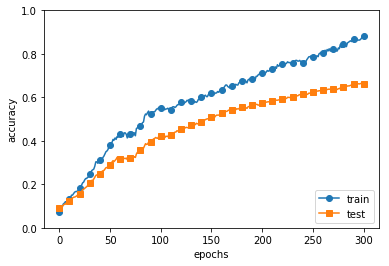

In [4]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex')) #載入父目錄檔案的設定
import numpy as np
import matplotlib.pyplot as plt
from dl_ex.dataset.mnist import load_mnist
from dl_ex.common.multi_layer_net_extend import MultiLayerNetExtend
from dl_ex.common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 減少學習數據以創建過度學習
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuout設定 ========================
use_dropout = True  
dropout_ratio = 0.15
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 繪圖==========
%matplotlib inline
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()


### 解說
我們可以看到，使用Droupout，訓練資料與測試資料的差距又縮小了。此外，訓練資料的準確度沒有達到100%。因此，使用Droupour之後，即使是表現複雜的神經網路，也可以控制過度學習問題。<br><br>

{Note}<br>
ML中，常用到整理學習( ensemble learning )。整體學習是指，個別學習多個模型，推論時，將這些輸出平均。從實驗中可以得知，進行整體學習，能讓神經網路的辨識準確度提高數%。<br>
而整體學習與Droupout有類似的關係。我們可以把再學習時，Droupout隨機刪除神經元的情況，解釋成每次學習不同模型。推論時，針對神經元的輸出，乘上刪除比例(如0.5等)取出模型的平均值。


## 6.5 驗證超參數
超參數若沒有經過妥善地設定，會造成效能不佳的模型，因此，超參數的值非常重要，但是決定超參數時，通常都伴隨著許多錯誤嘗試。以下將說明有效找出超參數的方法。


### 6.5.1 驗證資料
到目前為止，使用的資料集分為訓練資料與測試資料。利用訓練資料進行學習，使用測試資料評估一般化能力，藉此了解是否過度適應資料(過度學習)，還有一般化能力的程度。<br><br>

接下來，我們要設定各種超參數進行驗證。但這裡必須特別注意到，不可以使用測試資料來評估超參數效能。這點非常重要，卻是容易被忽略的地方。<br><br>

若使用測試資料調整超參數，超參數的值會對測試資料產生過度學習。這種作法等於用測試資料來確認超參數值得「好壞」，結果調整成只適合測試資料的超參數，無法適應其他資料，一般化能力低的模型。<br><br>

因此，調整超參數時，必須準備超參數專用的確認資料。超參數的調整用資料一般稱作**驗證資料( __validation data__ )**。利用這種資料來評估超參數的好壞。<br><br>

{Note}<br>
訓練資料是用來進行參數( 權重及偏權值 )學習，而驗證資料是用來評估超參數的效能。最後( 理想狀態是一次 ) 使用測試資料檢查一般化能力。


In [ ]:
from dl_ex.common.util import *
(x_train, t_train ) , (x_test, t_test ) = load_mnist()

# 混合訓練資料
x_trian, t_train = shuffle_dataset(x_train, t_train)

# 分割驗證資料
validation_rate = 0.2
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

"""

 再分割資料前，先混和輸入資料與訓練標籤。
 這是因為部分資料集可能有特別的資料傾向
 例如，數字「0」到「10」依序排列等
 接著，就用驗證資料來檢視超參數的最佳化手法。
 
"""


### 6.5.2 超參數的最佳化
執行超參數最佳化的關鍵在於，逐漸縮小「優良」超參數的範圍。逐漸縮小範圍是指，剛開始設定概略的範圍，從該範圍中，隨機選出超參數( 抽樣 )，利用樣本值評估辨識準確度。反覆重複數次，觀察辨識準確度的結果，再從結果中，縮小「優良」超參數的範圍。重複上述步驟，即可逐漸選出適當的超參數範圍。<br><br>

這邊的「概略」是指，以「10的次方」或「對數尺度」來設定，如0.001等。<br><br>

進行超參數最佳化時，必須注意到，深度學習的學習階段需要花費許多時間(例如，幾天)。因此，尋找超參數時，必須盡早可能排除不設合的超參數。在超參數最佳化的過程中，縮小學習用的循環週期( epoch )，能有效縮短每次評估所需的時間。<br><br>

我們將以上的思緒經整理歸納後，可以列出以下步驟。<br><br>

* 步驟0<br>
設定超參數的範圍。

* 步驟1 <br>
從設定的超參數範圍中，隨機抽樣。

* 步驟2 <br>
使用步驟1抽樣的超參數值進行學習，利用驗證資料評估辨識準確度(但是要設定成較小的epoch值)。

* 步驟3 <br>
重複進行步驟1與2多次(100、1000次等)，從辨識準確度的結果中，縮小超參數的範圍。

* 步驟4 <br>
重複進行以上操作，縮小超參數範圍至一定程度後，從該範圍中，選出一個超參數的值。<br><br>

然而，這只是一種超參數優化的方法，如果希望採取更為洗鍊的手法，可以使用**貝葉斯優化( _bayesian optimization_ )**，進行更有效率，數學更為嚴謹的超參數最佳化方法。


### 6.5.3 執行超參數最佳化
這裡使用MNIST資料集，進行超參數最佳化。我們以學習率(learning rate)以及控制Weight decay強度的係數，當作尋找超參數最佳化的對象。


val acc:0.35 | lr:0.0009809157052150877, weight decay:2.2895696539118772e-05
val acc:0.35 | lr:0.00047419656361321396, weight decay:6.264401422151056e-05
val acc:0.26 | lr:0.0004845767574149385, weight decay:1.2133643684876338e-08
val acc:0.16 | lr:0.00021753957461468276, weight decay:8.800408669789378e-05
val acc:0.1 | lr:1.0008849783212522e-06, weight decay:1.8764048695470265e-05
val acc:0.08 | lr:1.0977519497646429e-06, weight decay:4.797214992772997e-07
val acc:0.78 | lr:0.003920395210255009, weight decay:6.272056928674986e-06
val acc:0.6 | lr:0.0015208514068466268, weight decay:2.058992765503269e-06
val acc:0.77 | lr:0.0026015377711418567, weight decay:9.142646461331672e-08
val acc:0.13 | lr:0.0002064022468453543, weight decay:2.1663493170632166e-06
val acc:0.17 | lr:8.643946320224149e-05, weight decay:1.3589480068598226e-07
val acc:0.64 | lr:0.0014137276039195, weight decay:4.471852498608506e-05
val acc:0.19 | lr:0.0004896721903892236, weight decay:4.2505935290269e-05
val acc:0.1

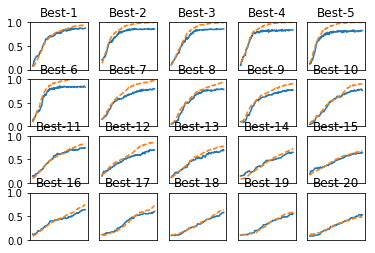

In [3]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex')) #載入父目錄檔案的設定
import numpy as np
import matplotlib.pyplot as plt
from dl_ex.dataset.mnist import load_mnist
from dl_ex.common.multi_layer_net import MultiLayerNet
from dl_ex.common.util import shuffle_dataset
from dl_ex.common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 減少訓練數據以加快學習速度
x_train = x_train[:500]
t_train = t_train[:500]

# 分離驗證集數據
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=150):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list

#  隨機搜索超參數======================================
optimization_trial = 100  # 隨機搜尋100個解
results_val = {}
results_train = {}

for _ in range(optimization_trial):
    # 指定搜索的超參數的範圍==========================
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)  # 這裡，test_acc_list作為val_acc_list的內 # 為何? (看不懂)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 繪圖=======================================================
%matplotlib inline
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


### 解說
如圖所示，依照辨識準確度的高低進行排序，顯示驗證資料的學習變化。檢視這張圖，可以得知到了某種程度(如Best-5)之前，神經網路都還能正確學習(不會overfitting)。


## 6.6 重點整理
本章節介紹了幾個再神經網路的學習時，非常重要的技巧。包括參數的更新方法、提供權重預設值的方法、還有Batch Normalization以及Droupout等，每一種對現在的神經網路而言，都是不可缺少的技術。此外，這裡學到的技術，也經常用於最先進的深度學習中。<br>

* 在參數的更新方法，除了SGD外，還有Momentum、AdaGrad、Adam等知名的手法。
* 提供權重預設值的方法，在進行正確的學習時，非常重要。
* 使用「Xavier預設值」、「He預設值」，當作權重的預設值，神經網路的學習效果會比較好。
* 使用Batch Normlization可以提升學習速度，而且不會過度依賴預設值，比較穩定。
* Weight dacay 與 Droupout 是控制過度學習用的正規化技術。
* 尋找超參數的有效方法是，逐漸縮小優良值存在的範圍。